<a href="https://colab.research.google.com/github/Kitenite/GAN_image_colorizing/blob/main/BWGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
hide
!pip install -Uqq fastbook
import fastbook
# fastbook.setup_book()
from fastbook import *
from PIL import Image, ImageDraw, ImageFont
from fastai.vision.all import *
from torchvision.utils import save_image
from fastai.vision.gan import *
import os

     |████████████████████████████████| 720 kB 12.7 MB/s 
     |████████████████████████████████| 1.2 MB 63.3 MB/s 
     |████████████████████████████████| 46 kB 5.8 MB/s 
     |████████████████████████████████| 189 kB 71.3 MB/s 
     |████████████████████████████████| 56 kB 6.4 MB/s 
     |████████████████████████████████| 51 kB 314 kB/s 


# Data

In [ ]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

- Grab image
- Make them all black and white
- Save in new folder

In [ ]:
train = path/'crappy'
gen = path/'gen'
original = path/'images'

train.mkdir(exist_ok=True)
gen.mkdir(exist_ok=True)

images = get_image_files(original)

# Make grey scale images
def crappify(i):
  img_name = str(i).split('/')[-1]
  img = Image.open(i)
  img = img.convert("L")
  img.save(f"{train}/{img_name}")

train.mkdir(exist_ok=True)
parallel(crappify, images)

(#7390) [None,None,None,None,None,None,None,None,None,None...]

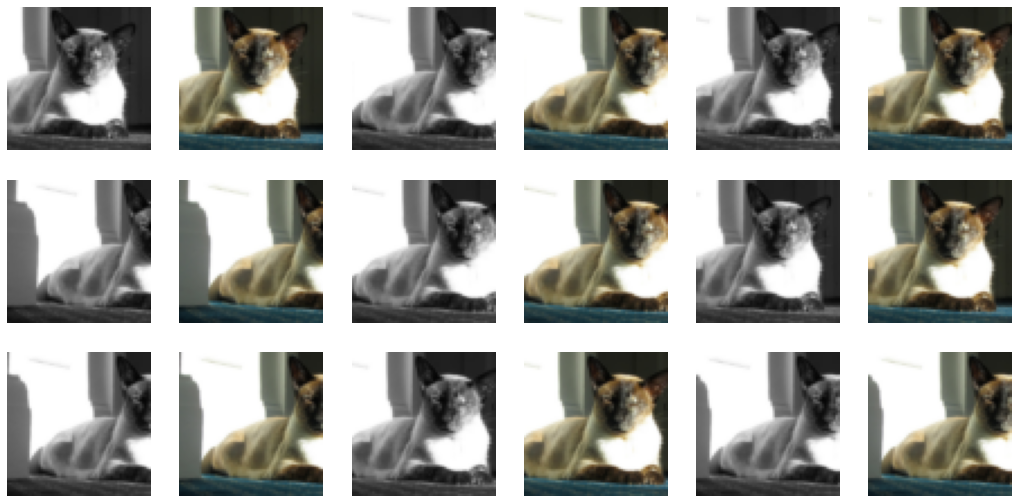

In [ ]:
# Make dataloaders
img_size = 64

def get_y_gen(x):
  fname = str(x).split('/')[-1]
  valid = original/fname
  return valid

db_gen = DataBlock(
    blocks=(ImageBlock,ImageBlock),
    item_tfms=Resize(img_size),
    batch_tfms=Normalize(imagenet_stats),
    splitter=RandomSplitter(),
    get_y=get_y_gen
)

# db.summary(train.ls(), bs=64, show_batch=True, unique=True)
dls_gen = db_gen.dataloaders(train.ls(), bs=64)
dls_gen.show_batch(unique=True) 

# Generator

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

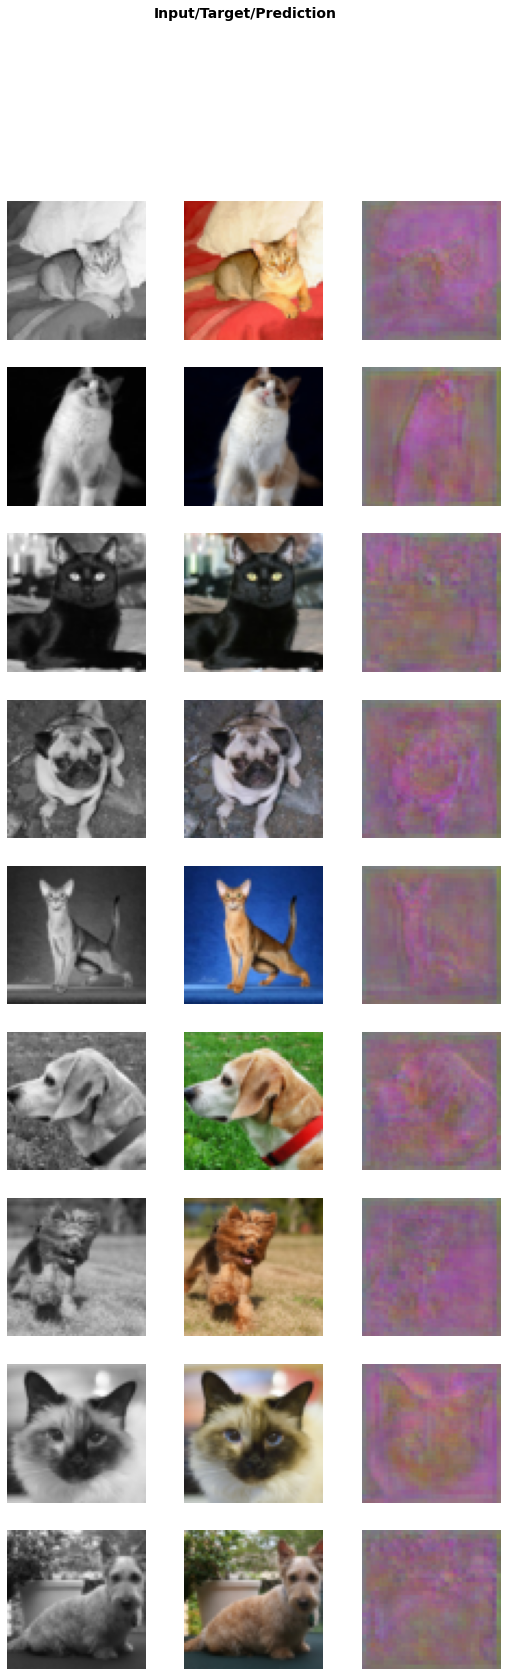

In [ ]:
wd = 1e-3
y_range_gen = (-3.,3.)
loss_func_gen = MSELossFlat(axis=1)

learn_gen = unet_learner(
    dls_gen, 
    models.resnet34, 
    loss_func=loss_func_gen, 
    y_range=y_range_gen, 
    wd=wd,
    blur=True, 
    norm_type=NormType.Weight,
    self_attention=True,
    n_out=3
  )

learn_gen.show_results()

In [ ]:
# learn_gen.lr_find()
# lr = 3e-4
# learn_gen.fit(2, lr=lr)

learn_gen.fit_one_cycle(4)

epoch,train_loss,valid_loss,time
0,0.134850,0.096100,01:04
1,0.090586,0.081699,01:03
2,0.078295,0.077936,01:02
3,0.074118,0.076393,01:03


In [ ]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.078249,0.078924,01:03
1,0.075059,0.076140,01:03
2,0.068947,0.074459,01:08


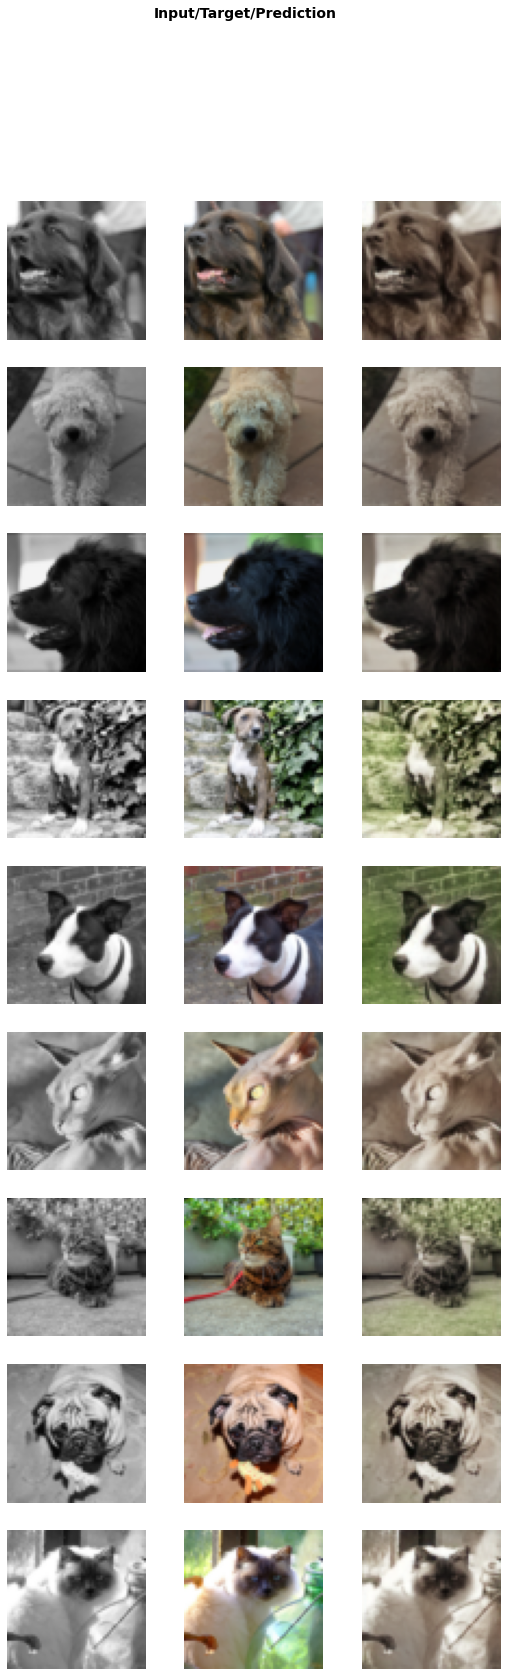

In [ ]:
learn_gen.show_results()

In [ ]:
learn_gen.save("learn_gen")

Path('models/learn_gen.pth')

In [ ]:
# Save generated images
def save_gen():
  i = 0
  for _ in range(50): 
    preds = learn_gen.get_preds()
    for p in preds:
      save_image(p, gen/f'{i}.png')
      print(gen/f'{i}.png')
      i+=1

save_gen()

/root/.fastai/data/oxford-iiit-pet/gen/0.png
/root/.fastai/data/oxford-iiit-pet/gen/1.png


/root/.fastai/data/oxford-iiit-pet/gen/2.png
/root/.fastai/data/oxford-iiit-pet/gen/3.png


/root/.fastai/data/oxford-iiit-pet/gen/4.png
/root/.fastai/data/oxford-iiit-pet/gen/5.png


/root/.fastai/data/oxford-iiit-pet/gen/6.png
/root/.fastai/data/oxford-iiit-pet/gen/7.png


/root/.fastai/data/oxford-iiit-pet/gen/8.png
/root/.fastai/data/oxford-iiit-pet/gen/9.png


/root/.fastai/data/oxford-iiit-pet/gen/10.png
/root/.fastai/data/oxford-iiit-pet/gen/11.png


/root/.fastai/data/oxford-iiit-pet/gen/12.png
/root/.fastai/data/oxford-iiit-pet/gen/13.png


/root/.fastai/data/oxford-iiit-pet/gen/14.png
/root/.fastai/data/oxford-iiit-pet/gen/15.png


/root/.fastai/data/oxford-iiit-pet/gen/16.png
/root/.fastai/data/oxford-iiit-pet/gen/17.png


/root/.fastai/data/oxford-iiit-pet/gen/18.png
/root/.fastai/data/oxford-iiit-pet/gen/19.png


/root/.fastai/data/oxford-iiit-pet/gen/20.png
/root/.fastai/data/oxford-iiit-pet/gen/21.png


/root/.fastai/data/oxford-iiit-pet/gen/22.png
/root/.fastai/data/oxford-iiit-pet/gen/23.png


/root/.fastai/data/oxford-iiit-pet/gen/24.png
/root/.fastai/data/oxford-iiit-pet/gen/25.png


/root/.fastai/data/oxford-iiit-pet/gen/26.png
/root/.fastai/data/oxford-iiit-pet/gen/27.png


KeyboardInterrupt: ignored

# Critic

2956 2956 5912


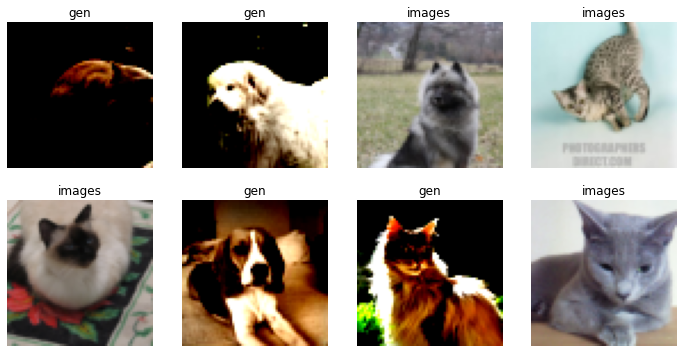

In [ ]:
# Get from gen, y from parent

def get_y_crit(x):
  fname = str(x.parent).split('/')[-1]
  return fname

db_crit = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    item_tfms=Resize(img_size),
    batch_tfms=Normalize(imagenet_stats),
    splitter=RandomSplitter(),
    get_y=get_y_crit
)

gen_imgs = get_image_files(gen)
original_imgs = get_image_files(original)[:len(gen_imgs)]
crit_imgs = original_imgs + gen_imgs
print(len(gen_imgs), len(original_imgs), len(crit_imgs))
# db.summary(train.ls(), bs=8, show_batch=True, unique=True)
dls_crit = db_crit.dataloaders(crit_imgs, bs=8)
dls_crit.show_batch() 

In [ ]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())
arch = basic_critic(
    in_size=img_size,
    n_channels=3
)

learn_crit = Learner(
    dls_crit, 
    arch, 
    metrics=accuracy_thresh_expand, 
    loss_func=loss_crit, 
    wd=wd
    )

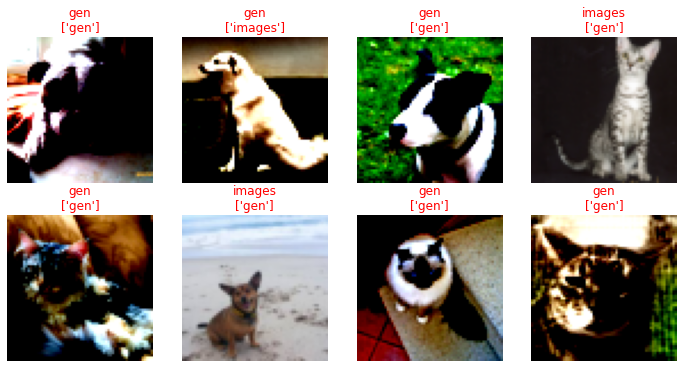

In [ ]:
learn_crit.show_results()

In [ ]:
learn_crit.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.188485,0.163484,0.964467,00:27
1,0.094197,0.103966,0.967851,00:26
2,0.067272,0.022430,0.992386,00:27
3,0.040587,0.022677,0.993232,00:26
4,0.019646,0.025076,0.993232,00:26
5,0.010590,0.020369,0.994924,00:26


# All together

In [ ]:
switcher = AdaptiveGANSwitcher
learn = GANLearner.from_learners(
    learn_gen, 
    learn_crit,
    weights_gen=(1.,50.), 
    show_img=False, 
    switcher=switcher,
    wd=wd
  )

In [ ]:
lr = 1e-4
learn.fit(40,lr)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,2.878258,4.657561,4.657561,0.933693,01:05
1,2.546052,4.462575,4.462575,0.760303,01:04
2,2.387570,4.733338,4.733338,0.732212,01:07
3,2.271209,4.542322,4.542322,0.619643,01:04
4,2.183673,4.778942,4.778942,0.561877,01:04
5,2.092251,4.602831,4.602831,0.601919,01:04
6,1.980256,4.446360,4.446360,0.393735,01:04
7,1.899104,4.893275,4.893275,0.300049,01:04
8,1.792913,4.458691,4.458691,0.406547,01:03
9,1.788409,4.552872,4.552872,0.206389,01:04


/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


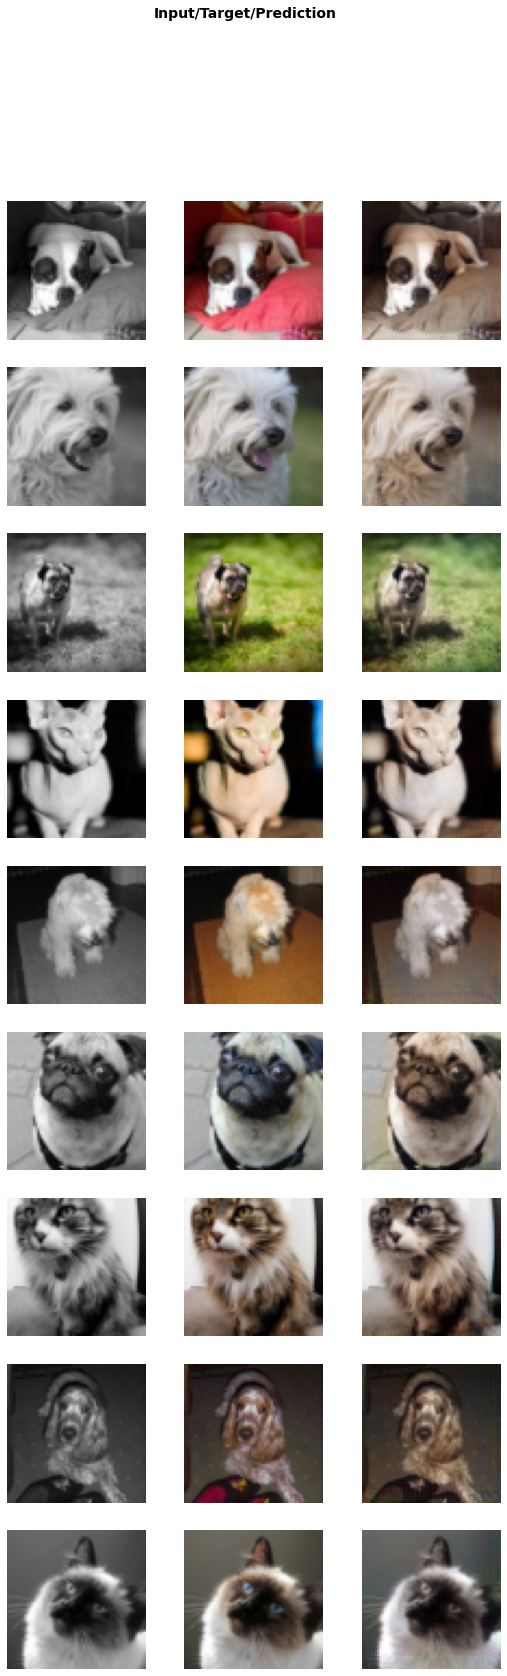

In [ ]:
learn.show_results()

In [ ]:
learn_gen.save('learn_gen_bw')
learn_crit.save('learn_crit_bw')
learn_gen.export('learn_gen_bw.pkl')
learn_crit.export('learn_crit_bw.pkl')

Conclusion: 

Kinda trash. The GANs generator is able to discern whenever something is grass and sky and correctly identify colors for those. 
However, for everything else, it seems that the best thing to do is to color everything a brown tint. 

We can see a huge improvement from a baseline generator to only using MSE without a critic. But not much improvement from having a critic itself.
This may be the effect of having a low skill requirement since there aren't really much color to contend with in these kind of pet images. 

The next step is to try a task a little bit more challenging: coloring manga. 

